# Bachelor Thesis
## MNIST classification using persistent homology

In [ ]:
!pip install giotto-tda
!pip install catboost
!pip install lightgbm
!pip install xgboost

     |████████████████████████████████| 1.5MB 27.5MB/s 
     |████████████████████████████████| 22.3MB 1.8MB/s 
     |████████████████████████████████| 27.4MB 1.5MB/s 
     |████████████████████████████████| 3.2MB 46.6MB/s 
     |████████████████████████████████| 13.2MB 128kB/s 
     |████████████████████████████████| 409kB 57.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 67.3MB 59kB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly as pl
from sklearn import datasets
from IPython.display import HTML

from sklearn.model_selection import train_test_split

from gtda.homology import CubicalPersistence
from gtda.images import Binarizer, RadialFiltration
from gtda.diagrams import Scaler

from gtda.diagrams import HeatKernel

from sklearn.pipeline import make_pipeline, make_union, Pipeline
from gtda.diagrams import PersistenceEntropy, Amplitude
from gtda.images import HeightFiltration

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### 1. Load MNIST Data and create train/test datasets

Let's load MNIST data

In [ ]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

In [ ]:
y = y.to_numpy()
X = X.to_numpy().reshape((-1, 28, 28))

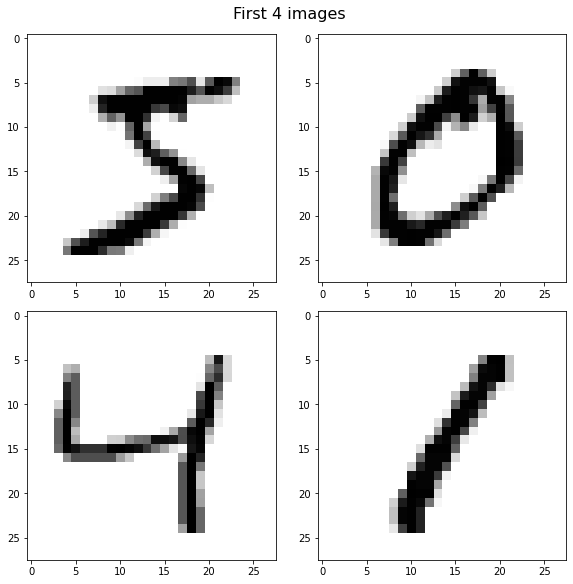

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X[i], cmap='gray_r')
fig.suptitle("First 4 images", fontsize = 16)
plt.show()

In [ ]:
train_size, test_size = 700, 300


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, random_state = 42, shuffle = True)

### 2. Create cubical complexes from data and extract topological features

I follow next pipeline:

![pipeline](images/pipeline.png)

#### 2.1 Binarization

In [ ]:
binarizer = Binarizer(threshold=0.4)

In [ ]:
X_bin = binarizer.fit_transform(X).reshape((-1, 28, 28))

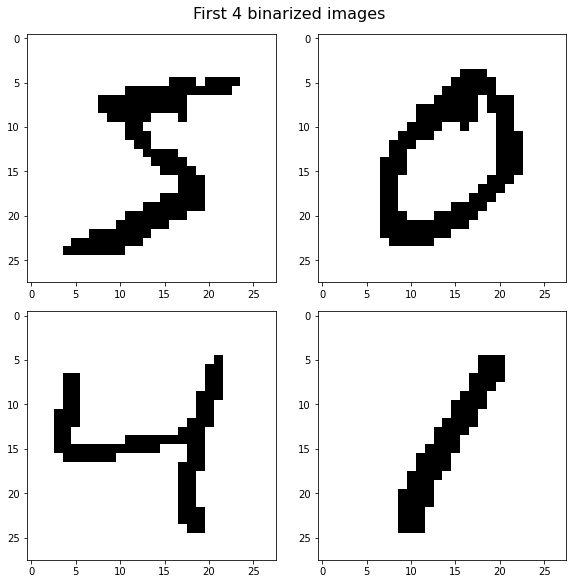

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X_bin[i], cmap = 'gray_r')
fig.suptitle("First 4 binarized images", fontsize = 16)
plt.show()

#### 2.2 Filtration

In [ ]:
radial_filtration = RadialFiltration(center=np.array([20, 6]))

In [ ]:
X_filt = radial_filtration.fit_transform(X_bin).reshape((-1, 28, 28))

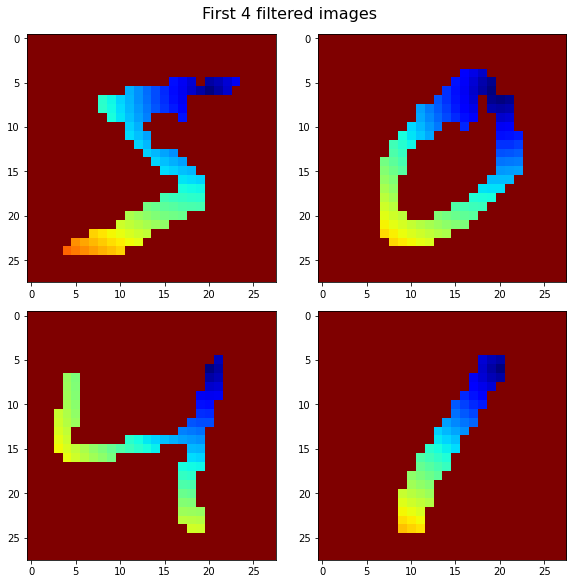

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X_filt[i], cmap = "jet")
fig.suptitle("First 4 filtered images", fontsize = 16)
plt.show()

#### 2.3 Persistence

In [ ]:
cubical_persistence = CubicalPersistence(n_jobs=-1)

In [ ]:
X_pers = cubical_persistence.fit_transform(X_filt)

In [ ]:
cubical_persistence.plot(X_pers[2][None, :, :])

#### 2.4 Scaling

In [ ]:
scaler = Scaler()

In [ ]:
X_scale = scaler.fit_transform(X_pers)

In [ ]:
scaler.plot(X_scale[0][None, :, :])

### 3. Vector representation

In [ ]:
heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)

In [ ]:
X_heat = heat.fit_transform(X_scale)

In [ ]:
heat.plot(X_heat[1][None, :, :], homology_dimension_idx=1, colorscale='jet')

### 4. Creating pipeline

In [ ]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]


feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)


In [ ]:
X_train_tda = tda_union.fit_transform(X_train)
X_test_tda = tda_union.transform(X_test)
X_train_tda.shape

(700, 476)

### 5. Classification

Random Forest Classifier:

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

rf.score(X_test_tda, y_test)

0.8833333333333333

Logistic Regression:

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_tda, y_train)

lr.score(X_test_tda, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9033333333333333

Support Vector Machine Classifier:

In [ ]:
svc = SVC(kernel='linear')
svc.fit(X_train_tda, y_train)

svc.score(X_test_tda, y_test)

0.8833333333333333

In [ ]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
lgbm = LGBMClassifier()

lgbm.fit(X_train_tda, y_train)
lgbm.score(X_test_tda, y_test)

0.8666666666666667

In [ ]:
# cat = CatBoostClassifier(iterations=10,
#                            learning_rate=1,
#                            depth=2,
#                            loss_function='MultiClass')

cat = CatBoostClassifier()

# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid_search_result = cat.grid_search(grid, 
#                                        X=X_train_tda, 
#                                        y=y_train, 
#                                        plot=True,
#                                        n_jobs=-1)

cat.fit(X_train_tda, y_train)

cat.score(X_test_tda, y_test)

In [ ]:
xgb = XGBClassifier()

xgb.fit(X_train_tda, y_train)
xgb.score(X_test_tda, y_test)

0.88

### 6. Tuning

#### 6.1 Feature Selection

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

bestFeatures = rf.feature_importances_.argsort()[-250:][::-1]
X_train_best = X_train_tda[:, bestFeatures]

#### 6.2 Tuning models

##### 6.2.1 Random Forest __(0.8842913563943607 for 200 features & 0.8742831639827348 for 250)__

In [ ]:
# rf_pipeline = Pipeline([
#     ('features', tda_union),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# threshold_list = [0.1, 0.4, 0.7, 0.9]
# direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
# n_estimators_list = [500, 1000, 2000]

# param_grid = {
#     #"filtration__direction": [np.array(direction) for direction in direction_list],
#     "classifier__n_estimators": [n_estimators for n_estimators in n_estimators_list],
#     'classifier__max_depth': [80, 90, 100],
#     'classifier__max_features': [2, 3, 4],
#     #'classifier__min_samples_leaf': [3, 4, 5],
#     #'classifier__min_samples_split': [8, 10, 12],
#     'classifier__n_estimators': [100, 200, 300, 1000]
# }

# grid_search = GridSearchCV(
#     estimator=rf_pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2
# )

# grid_search.fit(X_train, y_train)

rf_params = {
    "n_estimators": [500, 1000, 2000],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(
    estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1, verbose=4
)

rf_grid.fit(X_train_best, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [80, 90, 100], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=4)

In [ ]:
rf_grid.best_score_

0.8742831639827348

In [ ]:
rf_grid.best_params_

{'max_depth': 80,
 'max_features': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 200}

##### 6.2.2 Support Vector Machine __(0.901409828448455 for 200 features & 0.9113996796400231 for 250)__

In [ ]:
svm_params = {
    'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
    'C' : [10 ** i for i in range(-2, 3)],
    'degree' : [3, 5, 7],
    'coef0' : [j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
    'gamma' : ('scale', 'auto'),
    'decision_function_shape': ('ovr', 'ovo')
}

svm = SVC(random_state=42)

svm_grid = GridSearchCV(
    estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
)

svm_grid.fit(X_train_best, y_train)

Fitting 3 folds for each of 3600 candidates, totalling 10800 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'coef0': [1.0, 0.0625, 0.012345679012345678, 1.0,
                                   0.125, 0.037037037037037035, 1.0, 0.25,
                                   0.1111111111111111, 1.0, 0.5,
                                   0.3333333333333333, 1.0, 1.0, 1.0],
                         'decision_function_shape': ('ovr', 'ovo'),
                         'degree': [3, 5, 7], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'sigmoid', 'rbf', 'poly')},
             verbose=4)

In [ ]:
svm_grid.best_score_

0.9113996796400231

In [ ]:
svm_grid.best_params_

{'C': 1,
 'coef0': 1.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear'}

##### 6.2.3 Logistic Regression __(0.9028526710930146 for 200 features & 0.9099874056955602 for 250)__

In [ ]:
log_params = {
    "C" : np.logspace(-3,3,7), 
    "penalty" : ["l1","l2", "lasso"],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

log = LogisticRegression()

log_grid = GridSearchCV(
    estimator=log, param_grid=log_params, cv=3, n_jobs=-1, verbose=4
)

log_grid.fit(X_train_best, y_train)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.11429637 0.49996943
 0.49996943 0.35710355 0.49996943 0.49854493        nan        nan
        nan        nan        nan        nan        nan 0.24715405
        nan 0.11285353 0.73859482 0.73859482 0.68569874 0.73859482
 0.74001932        nan        nan        nan        nan        nan
        nan        nan 0.70000489        nan 0.7656848  0.83571769
 0.83571769 0.84428916 0.83571158 0.83571769        nan        nan
        nan        nan        nan        nan        nan 0.87571989
        nan 0.85430958 0.87858724 0.87858724 0.88144235 0.87573823
 0.87431373        nan        nan        nan        nan        nan
        nan        nan 0.90427717        nan 0.87430762 0.89857305
 0.89572405 0.90141594 0.88000562 0.87430151        nan        nan
        nan        nan        nan        nan        nan 0

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', 'lasso'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=4)

In [ ]:
log_grid.best_score_

0.9099874056955602

In [ ]:
log_grid.best_params_

{'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}

##### 6.2.4 CatBoost __(0.89 for both)__

In [ ]:
cat = CatBoostClassifier(task_type="GPU",
                           devices='0:1');

grid = {'learning_rate': [0.003, 0.03],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.03, 0.1, 1]}

grid_search_result = cat.grid_search(grid, 
                                       X=X_train_tda, 
                                       y=y_train, 
                                       plot=True)

NameError: ignored

In [ ]:
bestCat = CatBoostClassifier(**grid_search_result['params'])
bestCat.fit(X_train_tda, y_train)

In [ ]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [ ]:
bestCat.score(X_test_tda, y_test)

0.8933333333333333

### 7. Accuracy via number of features

In [ ]:
numOfFeatures = [50, 100, 150, 200, 250, 300, 350, 400, 450]
accuracies = []

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

for num in numOfFeatures:
    print(num)
    bestFeatures = rf.feature_importances_.argsort()[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]
    svc_num = SVC(random_state=42)
    svc_num.fit(X_train_best, y_train)
    X_test_num = tda_union.transform(X_test)[:, bestFeatures]
    accuracies.append(svc_num.score(X_test_num, y_test))


50
100
150
200
250
300
350
400
450


In [ ]:
print(accuracies)

[0.8566666666666667, 0.89, 0.8833333333333333, 0.8666666666666667, 0.8733333333333333, 0.8633333333333333, 0.8533333333333334, 0.8633333333333333, 0.8433333333333334]


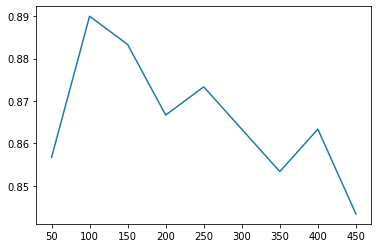

In [ ]:
plt.plot(numOfFeatures, accuracies)

In [ ]:
s = SVC(random_state=42)

X_train_part = X_train_tda[:, rf.feature_importances_.argsort()[-50:][::-1]]
s.fit(X_train_part, y_train)

X_test_num = tda_union.transform(X_test)[:, rf.feature_importances_.argsort()[-50:][::-1]]
s.score(X_test_num, y_test)

0.8566666666666667

### 8. Grid Search with different numbers of features

In [ ]:
numOfFeatures = [50, 100, 150, 200, 250, 300, 350, 400, 450]
params = []
scores = []
accuracies = []

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

svm_params = {
    'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
    'C' : [10 ** i for i in range(-2, 3)],
    'degree' : [3, 5, 7],
    'coef0' : [j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
    'gamma' : ('scale', 'auto'),
    'decision_function_shape': ('ovr', 'ovo')
}

for num in numOfFeatures:
    print(num)
    bestFeatures = rf.feature_importances_.argsort()[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]

    svm = SVC(random_state=42)

    svm_grid = GridSearchCV(
        estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
    )

    svm_grid.fit(X_train_best, y_train)

    params.append(svm_grid.best_params_)
    scores.append(svm_grid.best_score_)

    X_test_num = tda_union.transform(X_test)[:, bestFeatures]
    accuracies.append(svm_grid.best_estimator_.score(X_test_num, y_test))

50
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
100
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
150
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
200
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
250
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
300
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
350
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
400
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
450
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits


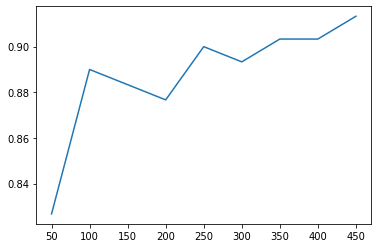

In [ ]:
plt.plot(numOfFeatures, accuracies)

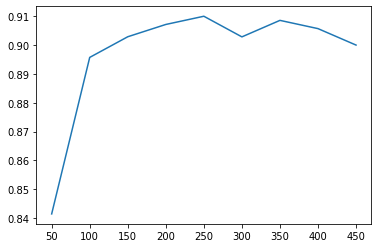

In [ ]:
plt.plot(numOfFeatures, scores)

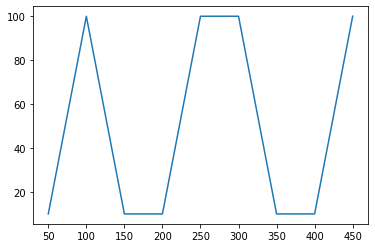

In [ ]:
cs = [params[i]['C'] for i in range(len(params))]
plt.plot(numOfFeatures, cs)